In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp # https://pypi.org/project/scikit-posthocs/
import stac
import matplotlib.pyplot as plt

In [10]:
pip install SAES==1.3.6


  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached sphinx-8.1.3-py3-none-any.whl.metadata (6.4 kB)
  Using cached sphinxcontrib_applehelp-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached sphinxcontrib_devhelp-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached sphinxcontrib_htmlhelp-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached sphinxcontrib_qthelp-2.0.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached pygments-2.19.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached docutils-0.21.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached babel-2.17.0-py3-none-any.whl.metadata (2.0 kB)
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.4 MB 16.7 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.4 MB 5.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.4 MB 5.9 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.4 MB 4.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.5.1 requires python-lsp-server[all]<1.11.0,>=1.10.0, but you have python-lsp-server 1.7.1 which is incompatible.


In [2]:
!pip install stac 

^C


# Read in our data for comparing

In [15]:
# Assumes a formattting where rows are datasets, and the methods are columns
df = pd.read_excel('auc_results34.xlsx')
data = np.asarray(df)

print("Read data")

# To be safe, ensure this matches what was expected
num_datasets, num_methods = data.shape
print("Methods:", num_methods, "Datasets:", num_datasets)

Read data
Methods: 5 Datasets: 8


## Friedman testing 
Non parametric test to check if there is a difference in means between the groups (classifiers)

In [16]:
alpha = 0.05 # Set this to the desired alpha/signifance level

stat, p = stats.friedmanchisquare(*data)

reject = p <= alpha
print("Should we reject H0 (i.e. is there a difference in the means) at the", (1-alpha)*100, "% confidence level?", reject)

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? False


### Post Hoc Analysis
See [Statistical Comparisons of Classifiers over Multiple Data Sets](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.141.3142&rep=rep1&type=pdf) for more detail

In [17]:
# At this point, we should only continue if H0 was rejected
if not reject:
    raise Exception("Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above")

Exception: Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above

In [18]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def plot(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

#### Nemenyi Test
Note: This is relevant when you would like to compare various methods.
For example if you propose several methods and want to compare them all against each
other, or to do an exhaustive comparison against several method. Often this is not
what we want, as we propose only one method (instead see Bonferoni below), and this would
be overconservativew. 

In [19]:
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comparisons
    pairwise_scores = pairwise_scores.set_axis(labels, axis='columns') # Label the cols
    pairwise_scores = pairwise_scores.set_axis(labels, axis='rows') # Label the rows
    return pairwise_scores

In [20]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, df.columns)

In [21]:
# Shows the p values for each pair
nemenyi_scores

,Random Forest,Balanced Random Forest,Adaboost,XGBoost,EasyEnsemble
Random Forest,1.000000,0.999860,0.022372,0.877740,0.712822
Balanced Random Forest,0.999860,1.000000,0.013570,0.933445,0.612726
Adaboost,0.022372,0.013570,1.000000,0.000736,0.409740
XGBoost,0.877740,0.933445,0.000736,1.000000,0.174542
EasyEnsemble,0.712822,0.612726,0.409740,0.174542,1.000000


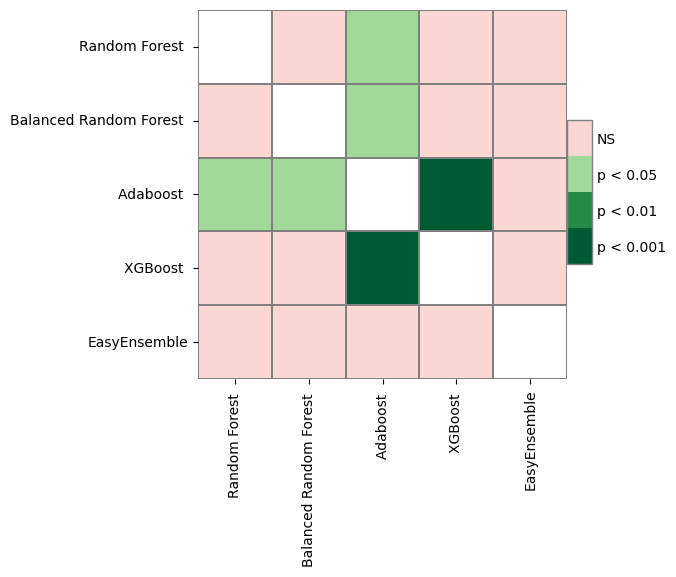

In [22]:
plot(nemenyi_scores)

<Axes: title={'center': '95.0% Confidence Intervals of the Mean'}>

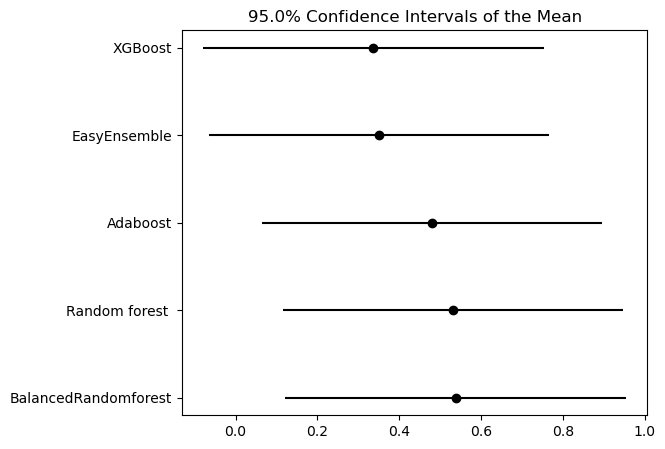

In [11]:
from autorank import autorank, create_report, plot_stats

# Run the autorank statistical test
result = autorank(nemenyi_scores, alpha=0.05, verbose=False)

# Plot the critical difference diagram
plot_stats(result, allow_insignificant=True)


Fail to reject null hypothesis that data is normal for column Random forest  (p=0.225882>=0.010000)
Fail to reject null hypothesis that data is normal for column BalancedRandomforest (p=0.324346>=0.010000)
Fail to reject null hypothesis that data is normal for column Adaboost (p=0.055406>=0.010000)
Fail to reject null hypothesis that data is normal for column XGBoost (p=0.202427>=0.010000)
Fail to reject null hypothesis that data is normal for column EasyEnsemble (p=0.276830>=0.010000)
Using Bartlett's test for homoscedacity of normally distributed data
Rejecting null hypothesis that all variances are equal (p=0.000000<0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000003)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
The statistical analysis was conducted for 5 populations with 8 paired samples.
The family-wise sig

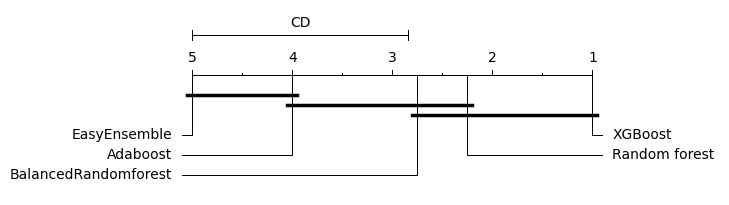

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, create_report, plot_stats

data = pd.read_excel('auc_results33.xlsx')

# Perform statistical analysis
results = autorank(data, alpha=0.05, verbose=True)

# Generate a textual report of the results
create_report(results)

# Corrected: Use results instead of data
plot_stats(results)
plt.show()


C:\Users\tee\AppData\Local\Temp\ipykernel_8624\2272463632.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric_Score', y='Model', data=df, palette='viridis')
C:\Users\tee\AppData\Local\Temp\ipykernel_8624\2272463632.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Prediction_Time_us', y='Model', data=df, palette='rocket')


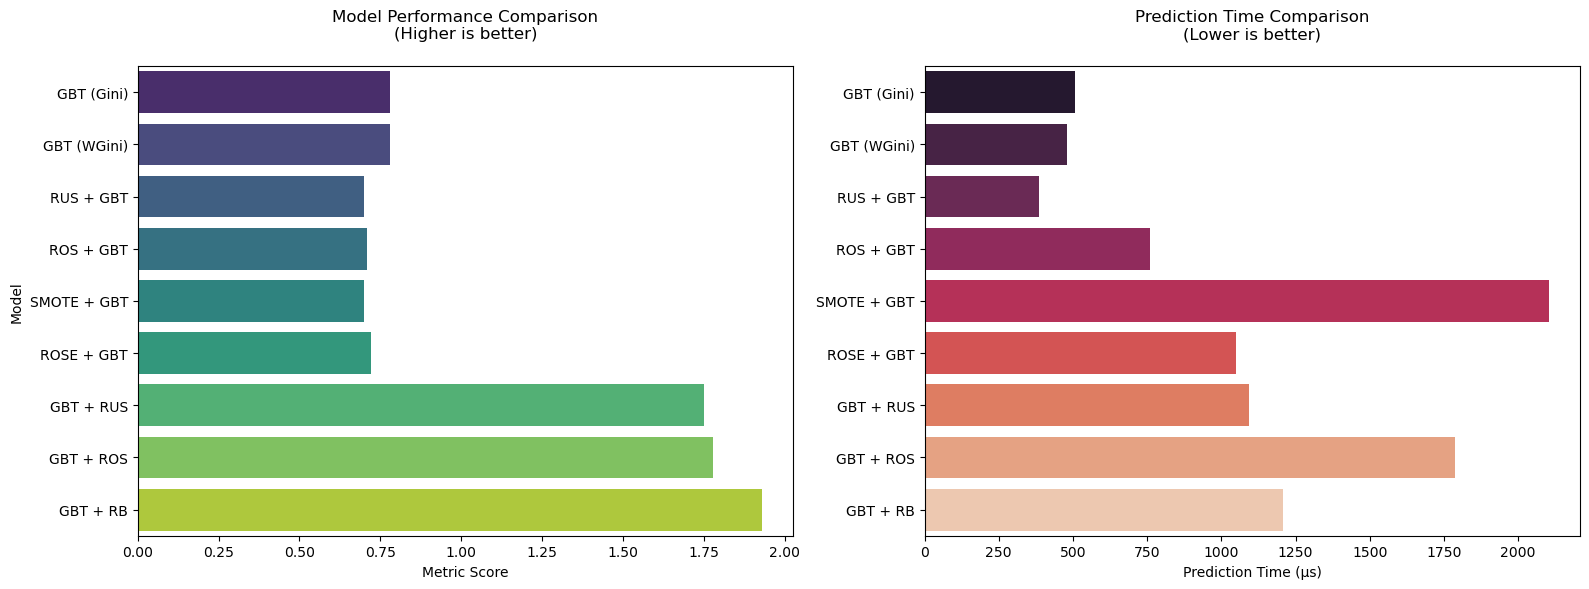

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame from the data
data = {
    'Model': [
        'GBT (Gini)', 'GBT (WGini)', 'RUS + GBT', 'ROS + GBT', 
        'SMOTE + GBT', 'ROSE + GBT', 'GBT + RUS', 'GBT + ROS', 'GBT + RB'
    ],
    'Metric_Score': [0.78, 0.78, 0.70, 0.71, 0.70, 0.72, 1.75, 1.78, 1.93],
    'Prediction_Time_us': [506.91, 479.05, 386.64, 757.88, 2103.06, 1049.96, 1094.05, 1786.06, 1207.65]
}

df = pd.DataFrame(data)

# Create side-by-side subplots
plt.figure(figsize=(16, 6))

# First plot - Metric Score
plt.subplot(1, 2, 1)
sns.barplot(x='Metric_Score', y='Model', data=df, palette='viridis')
plt.title('Model Performance Comparison\n(Higher is better)', pad=20)
plt.xlabel('Metric Score')
plt.ylabel('Model')

# Second plot - Prediction Time
plt.subplot(1, 2, 2)
sns.barplot(x='Prediction_Time_us', y='Model', data=df, palette='rocket')
plt.title('Prediction Time Comparison\n(Lower is better)', pad=20)
plt.xlabel('Prediction Time (μs)')
plt.ylabel('')  # Remove y-label to avoid duplication

plt.tight_layout()
plt.show()